# Basic Hand Movements Data Wrangling
The data is currently organized in dictionarys with a hierarchy of filename:'subject' -> grip_channel -> signal array. To follow best practices, each signal must be encoded as a seperate observation, along with categorical variables to identify subject, grip, channel number, grip_channel, and sex of each observation. For lack of a better way to format the data, each array of 3000 readings will be oriented as rows and each reading with be a column. 

In [21]:
#set envrionment
import pandas as pd
import numpy as np
import scipy.io as sio
import scipy as sp
import matplotlib.pyplot as plt
#load files
file_1 = sio.loadmat('female_1.mat')
file_2 = sio.loadmat('female_2.mat')
file_3 = sio.loadmat('female_3.mat')
file_4 = sio.loadmat('male_1')
file_5 = sio.loadmat('male_2')

In [22]:
#load each file as a df and concatenate them together
list_of_files = [('female_1',file_1),('female_2',file_2),('female_3',file_3),('male_1', file_4),('male_2',file_5)]

df = pd.DataFrame()

for file_name, dct in list_of_files:
    for grip, values in list(dct.items())[3:]:
        df_temp = pd.DataFrame.from_dict(dct[grip])
        df_temp['grip_channel'] = grip
        df_temp['subject'] = file_name
        df = pd.concat([df, df_temp])
#initialize categorical columns to label arrays        
df['channel'] = [x[-1] for x in df['grip_channel']]
df['grip'] = [x[:-4] for x in df['grip_channel']]
df['sex'] = [x[:-2] for x in df['subject']]

## Correcting the centrality of the signals
Each signal collected should be oriented around zero. Sometimes when the signal is collected though they are recorded off-center, so the mean of the array should be subtracted from each value. Additionally, the signal should be rectified by taking the absolute value of each reading which will be necessary in order to extract the approximate amplitude of the signal over time. 

In [23]:
#slice out the signal values. the apply function will only apply to the signal values
df_corrected = df.iloc[:,:3000]
#subtract the mean from each array and calculate the absolute value
df_centered = df_corrected.apply(lambda x: x - np.mean(x), axis=1)
df_corrected = df_centered.apply(lambda x: abs(x), axis=1)
#re-add the categorical values
df_corrected[['channel', 'grip', 'sex', 'grip_channel','subject']] = df[['channel', 'grip', 'sex', 'grip_channel','subject']]
df_corrected = df_corrected.reset_index(drop=True)

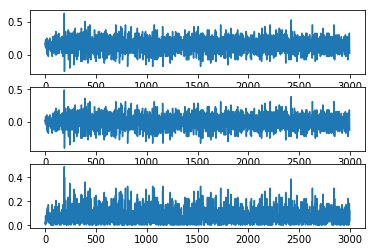

In [24]:
#example of the recentered data
plt.subplot(3,1,1)

plt.plot(df.iloc[900,:3000])

plt.subplot(3,1,2)

plt.plot(df_centered.iloc[900,:3000])

plt.subplot(3,1,3)

plt.plot(df_corrected.iloc[900,:3000])

## Calculate the signal envelope
A general technique used to extract the approximate activiation from a raw EMG signal is to use a lowpass filter to capture the shape of the envelope. 

In [25]:
from scipy import signal

def emg_envelope(array, low_pass_cutoff=10, sampling_frequency=500, order=4):
    
    "returns signal envelope approximating the activation of signal over time using the butterworth filter"
    "array = array containing signal"
    "low_pass_cutoff = A low pass filter allows frequencies below the cut-off frequency to pass through"
    "sampling_frequency = our samples were recorded at 500 samples a sec, so default to 500hz"
    'order = order of the butterworth filter'
    
    low_pass = low_pass_cutoff/sampling_frequency #Nyquist frequency for butterworth filter
    b, a = sp.signal.butter(order, low_pass, btype='lowpass') #4th order sampling is common default
    return sp.signal.filtfilt(b, a, abs(array))

In [26]:
#apply the function to all signals in the df and re-add categorical vars
envelope_df = df_corrected.iloc[:,:3000].apply(emg_envelope, axis=1)

envelope_df[['channel', 'grip', 'sex', 'grip_channel','subject']] = df_corrected[['channel', 'grip', 'sex', 'grip_channel', 'subject']]

In [27]:
#graph the average envelope for female_1 grips
female_1 = envelope_df.loc[(envelope_df['subject']=='female_1') & (envelope_df['channel'] == '1')]
mean_grip_f1 = female_1.groupby('grip').mean()

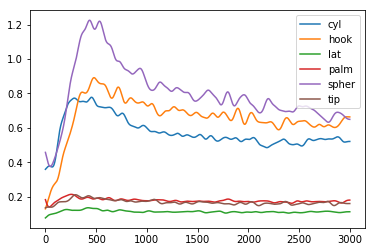

In [28]:
#sanity check. looks good so far
for x, y in mean_grip_f1.iterrows():
    plt.plot(y)

plt.legend(mean_grip_f1.index)

## Signal Reduction by Extracting Windowed Amplitudes
Another simpiler way to reduce number of features while still capturing the shape of the signal is the extract an amplitude value over a window of the data. In this situation I've selected the average value to represent the maximum activation, although the max value may be considered. By extracting the highest signal value from every 50 signals, I've reduced the number of variables from 3000 to 60 while still maintaining its shape. 

In [29]:
def extract_amplitudes(row, window=50):
    "takes an array and extracts the greatest amplitude from adjacent windows of specified size"
    "row = array of signals"
    "window = number of samples to extract ave from. windows are adjacent"
    amplitudes = np.array([])
    start = 0
    stop = window
    while stop <= 3000:
        amplitudes = np.append(amplitudes, np.mean(abs(row)[start:stop]))
        start += window
        stop += window
    #return array of max amplitudes per window
    return amplitudes

In [30]:
#because the function does not output the same shape of the input, .apply() wont work here
amp_adj_df = pd.DataFrame(columns = [i for i in range(60)])

index = 0

for x, y in df_corrected.iloc[:,:3000].iterrows():
    amplitudes = extract_amplitudes(y,window=50) #apply function to each row
    amp_adj_df.loc[index,:] = amplitudes #add extracted values to new df
    index += 1

In [31]:
#re-add categorical vars again
column_list = ['channel', 'grip', 'sex', 'grip_channel','subject']

amp_adj_df[column_list] = df_corrected[column_list]

In [32]:
#lets graph the average shape of signal female_1 'cyl_ch1'
this = amp_adj_df.loc[(amp_adj_df['subject'] == 'female_1') & (amp_adj_df['grip_channel'] == 'cyl_ch1')]

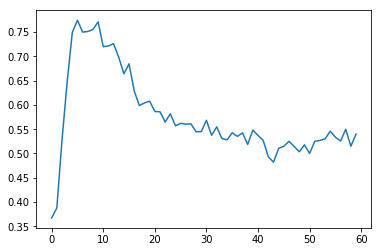

In [33]:
plt.plot(np.mean(this.iloc[:,:60], axis=0))

## Signal Reduction by Extracting Overlapping Windows
Like before, but this time with overlapping windows instead of adjacent windows. This results in a much smoother line. Additionally, using average of the windows instead of the max value gives a result even more similar to the lowpass filter with reduction by 50x. For consistency, I've sampled windows of 345 with an overlap of 300 so as to maintain 60 samples. 

In [34]:
def extract_amplitudes_overlapping(row, window=345, overlap=300):
    "takes an array and extracts the greatest amplitude from adjacent windows of specified size"
    "readings = array of signals"
    "window = number of samples to extract max from. windows are adjacent"
    amplitudes = np.array([])
    start = 0
    stop = window
    incriment = (window - overlap)
    while stop <= 3000:
        amplitudes = np.append(amplitudes, np.mean(abs(row)[start:stop]))
        start += incriment
        stop += incriment
    #return array of max amplitudes per window
    return amplitudes

In [35]:
#like before, apply the new extraction function
amp_ol_df = pd.DataFrame(columns = [i for i in range(60)])

index = 0

for x, y in df_corrected.iloc[:,:3000].iterrows():
    amplitudes_overlap = extract_amplitudes_overlapping(y, window=345, overlap=300)
    amp_ol_df.loc[index,:] = amplitudes_overlap
    index += 1

In [36]:
#re-add the categorical vars
amp_ol_df[column_list] = df_corrected[column_list]

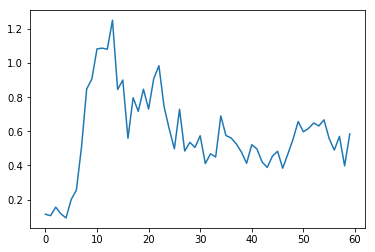

In [37]:
#here is a sample of the adj windows
plt.plot(amp_adj_df.iloc[0,:60])

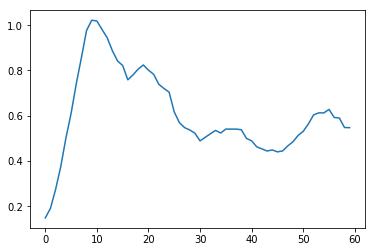

In [38]:
#compared to the overlapping samples
plt.plot(amp_ol_df.iloc[0,:60])

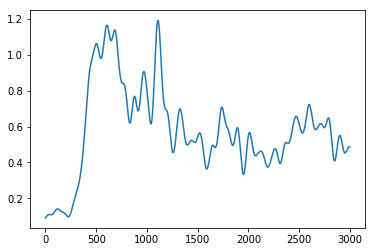

In [39]:
#compared to the envelop
plt.plot(envelope_df.iloc[0,:3000])